# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, 
grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#import some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

this image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


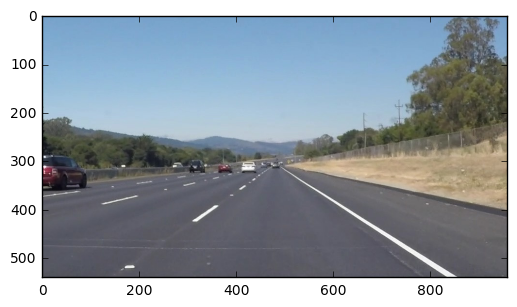

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#print out some stats and plotting
print('this image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [16]:
import math

# Global variables to store slopes of previous frames
prev_slope_right = 0.6
prev_slope_left = -0.6

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform
    Canny recommends a upper:lower ratio between 2:1 and 3:1"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero 
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # declare global variable for a first order filter
    global prev_slope_right
    global prev_slope_left
    alpha = 0.45
    
    #establish x-min and x-max coordinates for left and right lines  
    xmin_left, xmin_right = 0, int(img.shape[1]/2)+20
    xmax_left, xmax_right = int(img.shape[1]/2)-20, img.shape[1] 

    #collect y1, x1 and slope for left and right lines
    #look for (-) slope for left lines and (+) slope for right lines  
    slopes_left, slopes_right = [], []
    y1s_left, x1s_left = [], []
    y1s_right, x1s_right = [], []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
             # negative slope: line coordinates belongs to left line
            if (prev_slope_left*0.75) > slope > (prev_slope_left*1.25):  
                slopes_left += [slope]
                y1s_left += [y1]
                x1s_left += [x1]
            # positive slope: line coordinates belongs to right line
            elif (prev_slope_right*1.15) > slope > (prev_slope_right*0.85): 
                slopes_right += [slope]
                y1s_right += [y1]
                x1s_right += [x1]
    
    #average slopes for left and right lines
    avg_slope_left = np.mean(slopes_left)
    avg_slope_right = np.mean(slopes_right)
    
    #slope first order filters
    avg_slope_left = alpha * avg_slope_left + (1-alpha) * prev_slope_left
    avg_slope_left = alpha * avg_slope_left + (1-alpha) * prev_slope_left
   
    #update previous slope global variables
    prev_slope_left, prev_slope_right = avg_slope_left, avg_slope_right
    
    #compute ymin and ymax for the left line
    intercept_left = np.mean(y1s_left) - avg_slope_left * np.mean(x1s_left)
    ymin_left = intercept_left
    ymax_left = (avg_slope_left * xmax_left + (intercept_left))
    
    #compute ymin and ymax for right line 
    intercept_right = np.mean(y1s_right) - avg_slope_right * np.mean(x1s_right)
    ymin_right = (avg_slope_right * xmin_right + (intercept_right))
    ymax_right = (avg_slope_right * xmax_right + (intercept_right))
      
    #draw left and right lines
    if (slopes_left):       #safe gaurds for empty mean
        cv2.line(img, (xmin_left, int(ymin_left)), (xmax_left, int(ymax_left)), color, thickness)
    if (slopes_right):     #safe gaurds for empty mean
        cv2.line(img, (xmin_right, int(ymin_right)), (xmax_right, int(ymax_right)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape,3), dtype=np.uint8)
    draw_lines(line_img, lines, thickness=10)
    return line_img
    
#python 3 has suppor for cool math symbols

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

### Build Pipeline to Process Images to Find Lanes
* The function called `lane_finder` contains the steps to process image
* Detailed description of how the pipeline works can be found in the reflection section

In [13]:
def read_image(file_name):
    ''' 
    Function reads image base on file type 
    '''
    file_type = file_name[file_name.index('.')+1:]
    if file_type == 'jpg':
        image = mpimg.imread(file_name)
    elif file_type == 'png':
        image = (mpimg.imread(file_name)*255).astype('uint8')
    return image

def lane_finder(image):
    ''' 
    Function applies Canny Edge Detection and Hough Transform
    to draw lanes on the road in an image.
    '''
    #gray scale image
    gray = grayscale(image)
    
    #define kernel size apply Gaussian Smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    #define parameters for Canny Edge Detection and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    #create a masked edges image to isolate the region of interest
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    #define vertices of the masking polygon
    v1 = (0, image_height)
    v2 = (int(image_width/2 - image_width*.01), image_height/2 + int(image_height*.08))
    v3 = (int(image_width/2 + image_width*.01), image_height/2 + int(image_height*.08))
    v4 = (image_width, image_height)
    vertices = np.array([[v1, v2, v3, v4]], dtype=np.int32)
    
    #apply mask
    masked_edges = region_of_interest(edges, vertices)
    
    #define the Hough Transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 65
    min_line_length = 40
    max_line_gap = 250
    
    #run Hough Transform on the edge detected image to find lines
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    #draw the lines on the original image
    lane_lines = weighted_img(lines, image)
    return lane_lines

#### The Pipeline at Work with Test Images

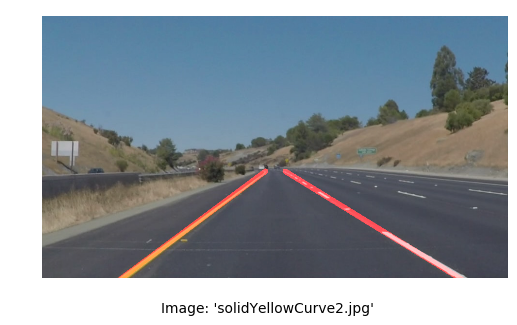

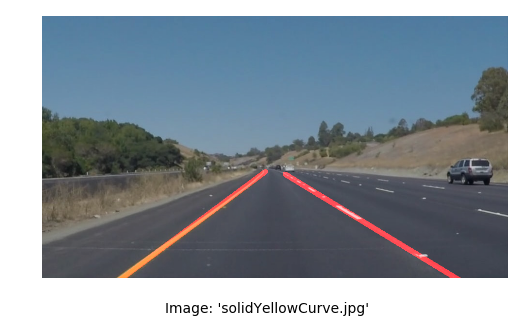

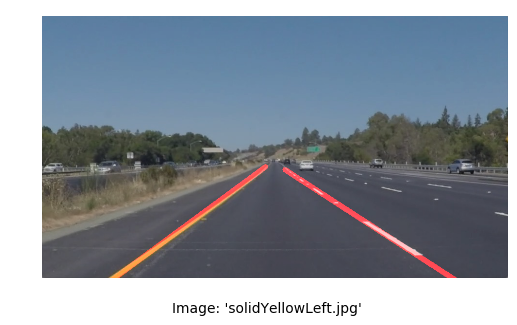

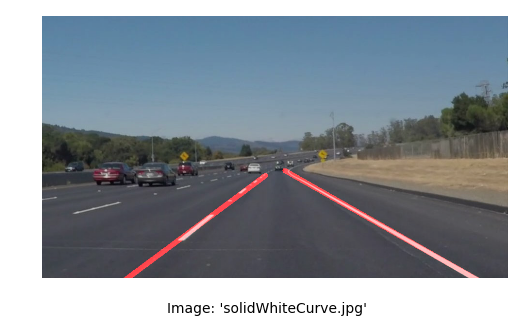

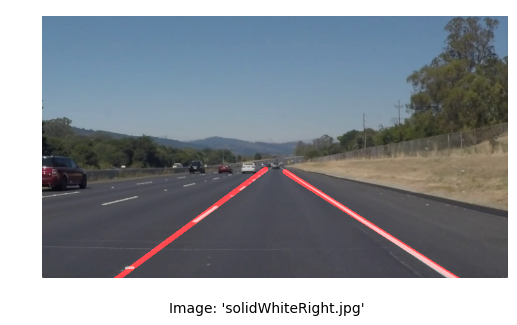

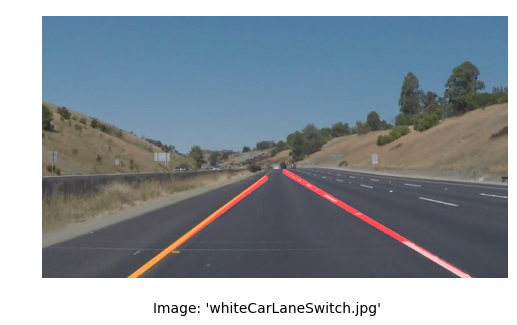

In [51]:
import os
PATH = "test_images/"
test_images = os.listdir(PATH)

#process all test images
for image in test_images:
    plt.figure().text(.5,.1,"Image: '" + image + "'", horizontalalignment="center" )
    plt.axis('off')
    plt.imshow(lane_finder(read_image(PATH + image)))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
#import everything needed ti edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return lane_finder(image)

Let's try the one with the solid white lane on the right first ...

In [17]:
# Set initial values for global variables
# Number are based on previous experiments
prev_slope_right = 0.6
prev_slope_left = -0.65

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 20.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 32 s, sys: 328 ms, total: 32.3 s
Wall time: 11.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
# Set initial values for global variables
# Number are based on previous experiments
prev_slope_right = 0.6
prev_slope_left = -0.6

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:38<00:00, 17.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 47s, sys: 1 s, total: 1min 48s
Wall time: 38.9 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Reflection Response

#### Pipeline Description
Procedure to find lane lines on images:
1. Change image to gray scale
2. Apply Guassian Blur (reduce noise)
3. Apply Canny Edge Detection
4. Mask the resulting image to only include the region of interest
5. Apply Hough Transform to extract Hough lines
6. Draw extrapolated lines to extend over the detected lane markings
 
Based on working on these steps most of the improvements to make the algorithm more robust can be applied to step 5 (Hough Transforms) and step 6 (extrapolate lines). More specifically: 

* **Filter out undesired slopes**(**IMPLEMENTED**): At times the slope of the lines from one frame to another is off by such a factor that it doesn't follow the general direction the lane. To counteract that effect a first order filter was implemented. This keeps a weighted average of the previous slopes calculated in past frames. When calculating the slope of the current frame it filter's it out by checking if it's above or below 15-25% of the past value.


* ** Reduce Jittery Lane Lines**(**IMPLEMENTED**): In my previous attempts, the lane lines followed the general direction of the lanes, but the variation of the line's slope from frame to frame was too abrupt and the lane lines jittered considerably. A first order filter was implemented to reduce this effect shown in the equation below.

    `filtered_slope = previous_slope + filter_factor*(current_slope-previous_slope)`
    `previous_slope = filtered_slope`

     where `filter_factor` must be a value between 0 and 1 (the lower the factor the slower the response of the filter). As a result the jittering of the lines was reduced as only incremental changes to the slope are made from frame to frame. Increasing Hough parameters will cause the filter to choose longer lines and ignore short lines, resulting in longer and smoother lines.


* **Curving Lanes**: As we all know, lane lines never stay straight. The current algorithm can only fit straight lines onto the road. In order for it to be applicable to the real world, it must be able to detect road curvatures. Currently we are only using two endpoints to fit our line. In order to better caputure the shape of the lanes, more points have to be used fot fit a curved line. A came across a paper in the ND forums that uses Hough Lines to do curve stitching, and it seems to be a viable solution to this problem. Reference: http://airccj.org/CSCP/vol5/csit53211.pdf


* **Lighting**: Shadows and poor lighting can affect the performance of the lane finding algorithm. Under those circumstances the Canny Edge Detection algorithm may fail to detect those lines for the Hough Transform. It is possible to lower the thresholds for Canny, but a more robust solution would be to process the image so that light intensity is the same throughout, apply a shadow removal algorithm, or extract lane line by color. Most of these can be achieve by changing the image from RGB color space to HSV or LAB space as these separate luminosity from color in an image. reference to a shadow removal algorithm: http://www.ijcsi.org/papers/IJCSI-10-4-2-270-273.pdf

#### Failure points
As of now my current algorithm would fail if:
 * The roads starts to curve as it is only drawing/extrapolating straight lines
 * If the lane lines start to fade or disappear
 * If the region of interest is no longer applicable to what the car camera is seeing
 * There are drastic changes in lighting such as shadows
 * The car changes lanes
 * There is a change to a more urban enviroment
